In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy
import torch

from splice import splice_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
sim_name = 'random_18.9k'
train = pickle.load(
        open(os.path.join("..", "data", "lgn-v1", sim_name, f"{sim_name}_train.pkl"), "rb")
    )
test = pickle.load(
    open(os.path.join("..", "data", "lgn-v1", sim_name, f"{sim_name}_test.pkl"), "rb")
)

lgn_train = torch.Tensor(train["responses"]["lgn"]).to(device)
v1_train = torch.Tensor(train["responses"]["v1"]).to(device)

lgn_test = torch.Tensor(test["responses"]["lgn"]).to(device)
v1_test = torch.Tensor(test["responses"]["v1"]).to(device)

In [12]:
train['stim_params']

{'x': array([57, 75, 83, ..., 34, 54, 55]),
 'y': array([88, 92, 59, ..., 13, 24, 81]),
 'lgn_p': array([ 6.57859424, 15.93220285, 14.03879414, ..., 14.45749954,
         9.5201603 ,  2.838217  ]),
 'v1_p': array([ 2.35645809, 17.46052906,  9.90654501, ..., 11.88604735,
         9.0298937 ,  3.67505542]),
 'stim_arr': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

In [3]:
model = splice_model(
    n_a = 400,
    n_b = 800,
    n_shared = 2,
    n_priv_a = 1,
    n_priv_b = 1,
    layers_enc = [200,200,200,200,200,200],
    layers_dec = [200,200,200,200,200,200],
    layers_msr = [200,200,200,200,200,200],
).to(device)

In [6]:
model.fit(lgn_train, v1_train, lgn_test, v1_test, disent_start=10000, c_disent=0.1, epochs=50000)

Epoch 0 	 source loss: 0.0540 | 0.0518 	 target loss: 0.0598 | 0.0574 	 disent loss: 1.0000 | 0.0000 	 msr loss: 0.0000 | 2.3973
Epoch 500 	 source loss: 0.0094 | 0.0096 	 target loss: 0.0112 | 0.0113 	 disent loss: 1.0000 | 278.6162 	 msr loss: 0.0000 | 309.3709
Epoch 1000 	 source loss: 0.0073 | 0.0078 	 target loss: 0.0085 | 0.0084 	 disent loss: 1.0000 | 272.5547 	 msr loss: 0.0000 | 306.6955
Epoch 1500 	 source loss: 0.0061 | 0.0064 	 target loss: 0.0071 | 0.0072 	 disent loss: 1.0000 | 309.1671 	 msr loss: 0.0000 | 349.3489
Epoch 2000 	 source loss: 0.0064 | 0.0067 	 target loss: 0.0071 | 0.0071 	 disent loss: 1.0000 | 88.2063 	 msr loss: 0.0000 | 103.7539
Epoch 2500 	 source loss: 0.0058 | 0.0061 	 target loss: 0.0052 | 0.0053 	 disent loss: 1.0000 | 111.6041 	 msr loss: 0.0000 | 130.1685
Epoch 3000 	 source loss: 0.0054 | 0.0058 	 target loss: 0.0036 | 0.0038 	 disent loss: 1.0000 | 121.1681 	 msr loss: 0.0000 | 141.4867
Epoch 3500 	 source loss: 0.0050 | 0.0054 	 target loss: 

In [14]:
# torch.save(model.state_dict(), os.path.join("..", "results", "models", "lgn-v1", f"{sim_name}_splice.pt"))

In [31]:
model.load_state_dict(torch.load(os.path.join("..", "results", "models", "lgn-v1", f"{sim_name}_splice2.pt")))

<All keys matched successfully>

In [32]:
model.fit_isomap_splice(lgn_train, v1_train, lgn_test, v1_test, disent_start=10000, c_disent=0.1, epochs=50000, n_neighbors=200)

Epoch 0 	 source loss: 0.0003 | 0.3545 	 target loss: 0.0004 | 0.7365 	 disent loss: 1.0000 | 0.0012 	 msr loss: 0.0000 | 2.0015 	 iso a loss: 10.8428 | 33.8683 	 iso b loss: 18.5255 | 50.2707
Epoch 500 	 source loss: 0.0173 | 0.0172 	 target loss: 0.0258 | 0.0234 	 disent loss: 1.0000 | 3996.9111 	 msr loss: 0.0000 | 12851.2812 	 iso a loss: 0.7252 | 0.1901 	 iso b loss: 0.3946 | 0.7968
Epoch 1000 	 source loss: 0.0095 | 0.0095 	 target loss: 0.0185 | 0.0180 	 disent loss: 1.0000 | 4024.2949 	 msr loss: 0.0000 | 12946.2480 	 iso a loss: 0.7255 | 0.1581 	 iso b loss: 0.3734 | 0.5648
Epoch 1500 	 source loss: 0.0079 | 0.0079 	 target loss: 0.0169 | 0.0170 	 disent loss: 1.0000 | 4160.4292 	 msr loss: 0.0000 | 13353.6045 	 iso a loss: 0.7244 | 0.1283 	 iso b loss: 0.3739 | 0.4891
Epoch 2000 	 source loss: 0.0071 | 0.0071 	 target loss: 0.0141 | 0.0152 	 disent loss: 1.0000 | 4160.1792 	 msr loss: 0.0000 | 13350.4775 	 iso a loss: 0.7214 | 0.1283 	 iso b loss: 0.3705 | 0.4359
Epoch 2500 	

In [33]:
z_a, z_b2a, z_a2b, z_b, m_b2a, m_a2b, a_hat, b_hat = model(
                        lgn_test, v1_test
                    )

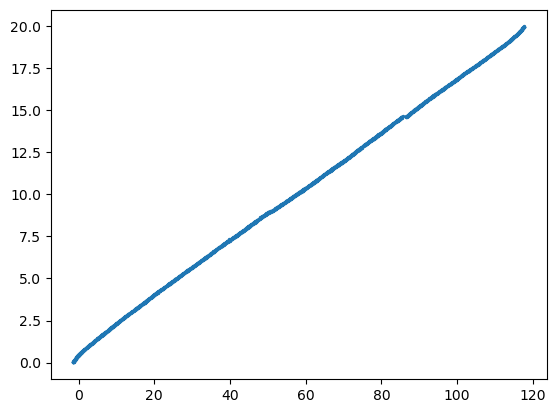

In [45]:
plt.scatter(z_b.detach().cpu().numpy(), test['stim_params']['v1_p'], s=2)

In [34]:
torch.save(model.state_dict(), os.path.join("..", "results", "models", "lgn-v1", f"{sim_name}_splice_isomap.pt"))